In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import os
from pandas.tseries.offsets import DateOffset

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.stattools import adfuller

In [2]:
filename = "../data/Alcohol_Sales.csv"
img_path = '../plots/forecasting/'

In [3]:
df_sales = pd.read_csv(filename, parse_dates=['DATE'])
display(df_sales.head)
display(df_sales.describe())

<bound method NDFrame.head of           DATE  S4248SM144NCEN
0   1992-01-01            3459
1   1992-02-01            3458
2   1992-03-01            4002
3   1992-04-01            4564
4   1992-05-01            4221
..         ...             ...
320 2018-09-01           12396
321 2018-10-01           13914
322 2018-11-01           14174
323 2018-12-01           15504
324 2019-01-01           10718

[325 rows x 2 columns]>

,S4248SM144NCEN
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


In [4]:

df_sales.index = df_sales['DATE']
df_sales = df_sales.drop(['DATE'], axis=1)
df_sales.index = df_sales.index.rename('time')
display(df_sales)
display(df_sales.describe())
df_sales = df_sales.rename(columns={"S4248SM144NCEN": "Sales"})
sales_title = df_sales.columns[0]
df_sales.isna().sum()

,S4248SM144NCEN
time,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


,S4248SM144NCEN
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


Sales    0
dtype: int64

In [5]:
df_sales_arima = df_sales.copy()

In [6]:
# Useful functions

def get_test_train_split(df, split=0.2):
    split_nb = int(len(df)*split)
    train, test = df.iloc[:-split_nb], df.iloc[-split_nb:]
    train.index = pd.to_datetime(train.index)
    test.index = pd.to_datetime(test.index)
    return train, test

def base_model(df):
    """Predict a  with previous observation"""
    data = df.values
    pred_data = np.roll(data, shift=1, axis=None)
    pred_data[0] = data[0]
    
    return pred_data

def model_evaluation(true_val, pred_val):
    """Get the Root Mean Square Error and Mean Absolute Error"""
    rmse = np.sqrt(mean_squared_error(true_val, pred_val))
    mae = mean_absolute_error(true_val, pred_val)
    return rmse, mae

In [7]:
train,test = get_test_train_split(df_sales_arima, 0.2)

In [8]:
display(train.head)

<bound method NDFrame.head of             Sales
time             
1992-01-01   3459
1992-02-01   3458
1992-03-01   4002
1992-04-01   4564
1992-05-01   4221
...           ...
2013-04-01  10493
2013-05-01  12218
2013-06-01  11385
2013-07-01  11186
2013-08-01  11462

[260 rows x 1 columns]>

# Baseline model - predicting previous observation

In [9]:

pred_train_base = base_model(train)
pred_test_base = base_model(test)
base_rmse_train, base_mae_train = model_evaluation(train['Sales'], pred_train_base)
base_rmse_test, base_mae_test = model_evaluation(test['Sales'], pred_test_base)
#print("Base model, rmse Train Error: ", base_rmse_train) 
#print("Base model, rmse Test Error: ", base_rmse_test) 


print('Train data')
print('Base model RMSE: ', base_rmse_train) # RMSE
print('Base model MAE: ', base_mae_train)  # MAE


print('\n')
print('Test data')
print('Base model RMSE: ', base_rmse_test) 
print('Base model MAE: ', base_mae_test)


Train data
Base model RMSE:  1088.2289086825012
Base model MAE:  756.1884615384615


Test data
Base model RMSE:  1999.1991781326226
Base model MAE:  1513.5692307692307


# ARIMA/SARIMA model

In [10]:
# Check that data is stationary (for confirmation) by use of adfuller

test_stationary = adfuller(df_sales_arima['Sales'])

# H0(Null Hypothesis) : Data is non-stationary
# H1 : Data is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis(H0), reject the null hypothesis. Data is stationary")
    else:
        print("\nWeak evidence against null hypothesis,indicating that data is non-stationary ")

adfuller_test(df_sales_arima['Sales'])

ADF Test Statistic : 2.0374047259136874
p-value : 0.9987196267088919
#Lags Used : 14
Number of Observations : 310

Weak evidence against null hypothesis,indicating that data is non-stationary 


In [11]:
# Checking the first difference and seasonal difference.

df_sales_arima['Sales First Difference'] = df_sales_arima['Sales'] - df_sales_arima['Sales'].shift(1)
df_sales_arima['Seasonal First Difference']=df_sales_arima['Sales']-df_sales_arima['Sales'].shift(12)
df_sales_arima.head()

,Sales,Sales First Difference,Seasonal First Difference
time,,,
1992-01-01,3459,NaN,NaN
1992-02-01,3458,-1.0,NaN
1992-03-01,4002,544.0,NaN
1992-04-01,4564,562.0,NaN
1992-05-01,4221,-343.0,NaN


In [12]:
#Check stationarity for Seasonal First Difference

adfuller_test(df_sales_arima['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.3393107296695432
p-value : 0.013210159306746407
#Lags Used : 13
Number of Observations : 299

Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='time'>

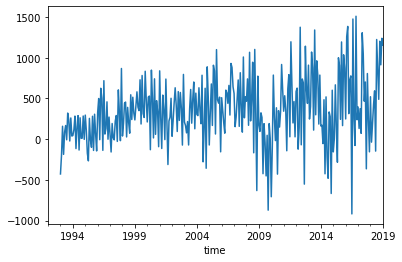

In [13]:
df_sales_arima['Seasonal First Difference'].plot()

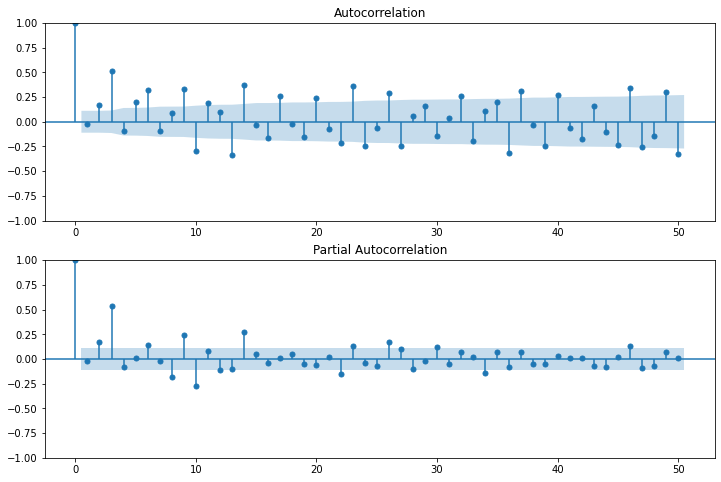

In [14]:
#Check autocorrelation plot, stationary data


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sales_arima['Seasonal First Difference'].dropna(),lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sales_arima['Seasonal First Difference'].dropna(),lags=50,ax=ax2, method='ywm')

In [15]:
# Forecast for non-seasonal data
#p=1, d=1, q=0 or 1
# Do training on train data then evaluate the forecast on test data

#train_new = train.copy()
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)

arima_model = ARIMA(train['Sales'],order=(1,1,1))
arima_model_fitted = arima_model.fit()
arima_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  260
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2122.720
Date:                Mon, 13 Dec 2021   AIC                           4251.439
Time:                        23:36:26   BIC                           4262.110
Sample:                    01-01-1992   HQIC                          4255.729
                         - 08-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1313      0.074      1.770      0.077      -0.014       0.277
ma.L1         -0.8711      0.036    -24.084      0.000      -0.942      -0.800
sigma2      7.595e+05   6.81e+04     11.161      0.000    6.26e+05    8.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                74.87
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               3.84   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5224/3873047411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['forecast'] = arima_model_fitted.predict(start = train.index.get_loc('2009-04-01'), end = train.index.get_loc('2013-08-1'), dynamic = True)


<AxesSubplot:>

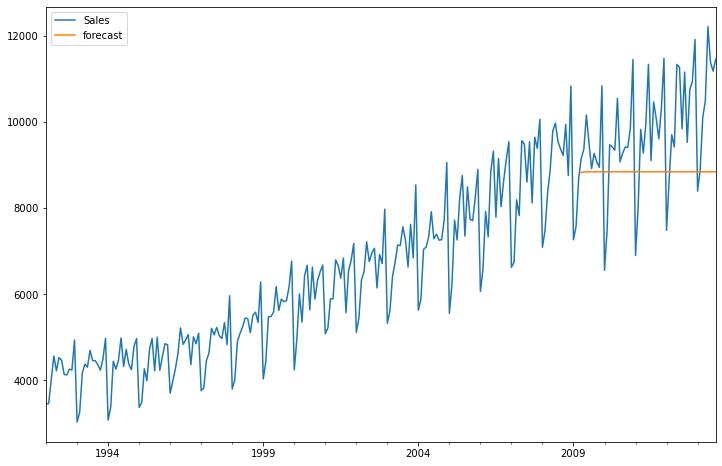

In [16]:
# Check the forecast on training data
#train['forecast'] = arima_model_fitted.predict(start=209,end=260,dynamic=True)
train['forecast'] = arima_model_fitted.predict(start = train.index.get_loc('2009-04-01'), end = train.index.get_loc('2013-08-1'), dynamic = True)
train[['Sales','forecast']].plot(figsize = (12,8))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5224/1472866424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['forecast_new']=sarimax_model_fitted.predict(start = train.index.get_loc('2009-04-01'), end = train.index.get_loc('2013-08-1'), dynamic = True)


<AxesSubplot:>

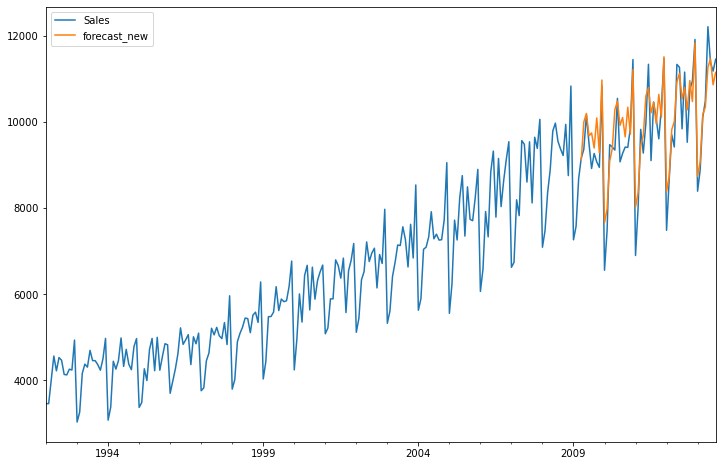

In [17]:
import statsmodels.api as sm
sarimax_model = sm.tsa.statespace.SARIMAX(train['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
sarimax_model_fitted = sarimax_model.fit()
train['forecast_new']=sarimax_model_fitted.predict(start = train.index.get_loc('2009-04-01'), end = train.index.get_loc('2013-08-1'), dynamic = True)
train[['Sales','forecast_new']].plot(figsize=(12,8))

<AxesSubplot:>

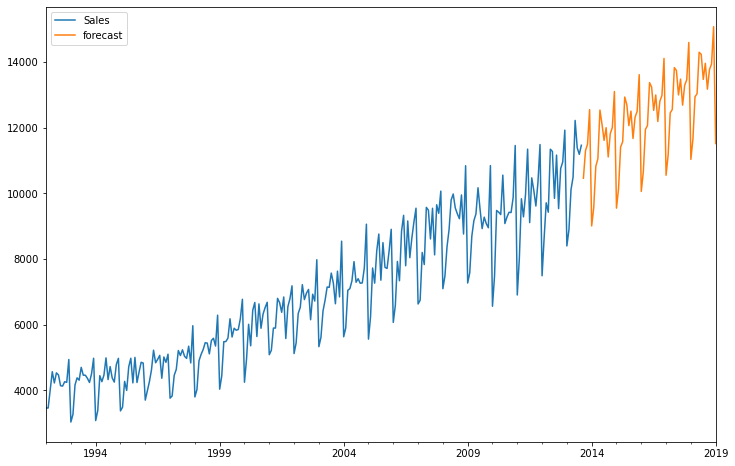

In [18]:

future_dates = [train.index[-1]+ DateOffset(months=x)for x in range(0,66)]
future_dates_df = pd.DataFrame(index=future_dates[1:], columns = train.columns)

future_dates_df.tail()

future_df=pd.concat([train, future_dates_df])

future_df['forecast'] = sarimax_model_fitted.predict(start = 260, end = 325)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

In [19]:
sarimax_pred = pd.DataFrame(np.array(future_df.loc[(future_df.index >= '2013-09-01') & (future_df.index <= '2019-01-01')]['forecast']), columns = ['Sales_pred'])
sarimax_pred.head

<bound method NDFrame.head of       Sales_pred
0   10456.807229
1   11293.604943
2   11498.292053
3   12546.467633
4    9004.700806
..           ...
60  13171.037962
61  13768.684506
62  13936.870122
63  15073.920253
64  11513.491954

[65 rows x 1 columns]>

In [20]:
# Model evaluation on test data

sarimax_rmse_test, sarimax_mae_test = model_evaluation(test['Sales'], sarimax_pred)

print('Test data')
print('SARIMAX model RMSE: ', sarimax_rmse_test) 
print('SARIMAX model MAE: ', sarimax_mae_test)

# Baseline model
print('\n')
print('Test data')
print('Base model RMSE: ', base_rmse_test) 
print('Base model MAE: ', base_mae_test)

Test data
SARIMAX model RMSE:  761.3227131400108
SARIMAX model MAE:  607.650723022653


Test data
Base model RMSE:  1999.1991781326226
Base model MAE:  1513.5692307692307


# Conclusion

By comparing the results above, It is noticeable that SARIMAX performs far better that just predicting previous observation
(baseline). The prediction error is less than half lower for SARIMAX compared to Baseline model.

In [21]:
display(df_sales_arima.head)

<bound method NDFrame.head of             Sales  Sales First Difference  Seasonal First Difference
time                                                                
1992-01-01   3459                     NaN                        NaN
1992-02-01   3458                    -1.0                        NaN
1992-03-01   4002                   544.0                        NaN
1992-04-01   4564                   562.0                        NaN
1992-05-01   4221                  -343.0                        NaN
...           ...                     ...                        ...
2018-09-01  12396                 -1861.0                      489.0
2018-10-01  13914                  1518.0                     1203.0
2018-11-01  14174                   260.0                      913.0
2018-12-01  15504                  1330.0                     1239.0
2019-01-01  10718                 -4786.0                     1154.0

[325 rows x 3 columns]>